<div style="text-align:right;">Justine Charrel - Master 1 Internship</div>

This script is used to realize unsupervised machine learning (self-organizing maps) of temperature of ERA5.

### IMPORT

In [1]:
from netCDF4 import Dataset as ncfile
from minisom import MiniSom
import matplotlib.pyplot as plt
import time
import numpy as np
from pylab import pcolor,colorbar,bone
from hyperopt import fmin, tpe, hp

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
from matplotlib.pyplot import cm
import matplotlib as mpl
from numpy.linalg import norm
import sys

### READ DATA

In [2]:
ppidir = '/lustre/storeB/users/justinec/master_internship/data/ERA5_MOSAiC/'
data_link  = ppidir + 'concatenated_ERA5_MOSAiC.nc'

dataset = ncfile(data_link,'r')    #dataset of radiosoundings of MOSAiC and ERA5

In [3]:
pres = dataset.variables['pres'][:]
data = dataset.variables['rh_era5'][:]

### SELF-ORGANIZING MAPS

#### Set hyperparameters

In [4]:
#int(np.sqrt(5*np.sqrt(len(data)))) #to determine max size of the SOM map (Vesanto,2005)
x = 4
y = 4
input_len = len(data[1])
iterations = 10000
sigma = 0.8
learning_rate = 0.1

#### Train and plot SOM

In [5]:
def train_som(x, y, input_len, sigma, learning_rate):
    
    # initialization of x*y SOM
    som = MiniSom(x=x, 
                  y=y, 
                  input_len=input_len, 
                  sigma=sigma, 
                  learning_rate=learning_rate)
    som.random_weights_init(data)
    
    # training
    start_time = time.time()
    som.train_random(data,iterations)
    elapsed_time = time.time() - start_time
    print(elapsed_time, "seconds")
    print('total_q_error :', som.quantization_error(data))
    
    return som

In [6]:
som = train_som(x, y, input_len, sigma, learning_rate)

1.238828182220459 seconds
total_q_error : 63.35990763618952


In [7]:
def plot_som(som):
    plt.figure(figsize=(6, 6))
    plt.imshow(som.distance_map()) #normalised sum of the distances between a neuron and its neighbours (euclidean distance)
    plt.colorbar()
    ax = plt.gca()
    ax.set_xticks(np.arange(-.5, 4, 1))
    ax.set_yticks(np.arange(-.5, 4, 1))
    ax.set_xticklabels(np.arange(0, 5, 1))
    ax.set_yticklabels(np.arange(0, 5, 1))

In [8]:
som.distance_map()

array([[0.32668758, 0.62585181, 0.4842471 , 0.29669454],
       [0.61487347, 0.92693856, 0.97124368, 0.45223382],
       [0.65795314, 1.        , 0.86657331, 0.5262752 ],
       [0.34227581, 0.57178724, 0.47755259, 0.33094177]])

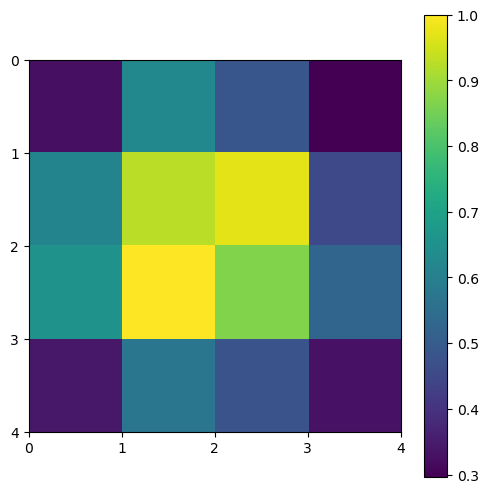

In [9]:
plot_som(som)

#### Tuning sigma by reducing quantization error with hyperopt.fmin

In [99]:
start_time = time.time()
best = fmin(
    fn=lambda sig: MiniSom(x=x, 
              y=y, 
              input_len=input_len, 
              sigma=sig, 
              learning_rate=learning_rate).quantization_error(data),
    space=hp.uniform("sig", 0.001, x / 2.01),
    algo=tpe.suggest,
    max_evals=200)
elapsed_time = time.time() - start_time
print(elapsed_time, "seconds")
print(best)

100%|██████| 200/200 [00:00<00:00, 340.98trial/s, best loss: 436.04382986597784]
0.5899591445922852 seconds
{'sig': 0.3452170545343276}


In [100]:
sigma = best['sig']
print("x: {}\ny: {}\ninput_len: {}\nsigma: {}\nlearning_rate: {}".format(x,y,len(data[1]),sigma,learning_rate))

x: 4
y: 4
input_len: 29
sigma: 0.3452170545343276
learning_rate: 0.1


#### Train and plot SOM with new sigma setting

1.30086088180542 seconds
total_q_error : 65.05881644131652


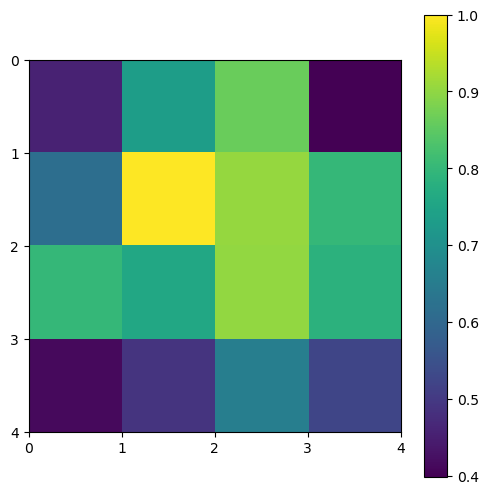

In [101]:
som = train_som(x, y, input_len, sigma, learning_rate)
plot_som(som)

#### Optimizing sigma and learning rate

In [102]:
from hyperopt import Trials, STATUS_OK

space={
        'sig': hp.uniform('sig', 0.001, 5),
        'learning_rate': hp.uniform('learning_rate', 0.001, 5)
    }
def som_fn(space):
    sig = space['sig']
    learning_rate = space['learning_rate']
    val = MiniSom(x=x, 
                  y=y, 
                  input_len=input_len, 
                  sigma=sig, 
                  learning_rate=learning_rate).quantization_error(data)
    #print(val)
    return {'loss': val, 'status': STATUS_OK}

trials =  Trials()
best = fmin(fn=som_fn,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print('best: {}'.format(best))
for i, trial in enumerate(trials.trials[:2]):
    print(i, trial)

100%|███████| 100/100 [00:00<00:00, 278.83trial/s, best loss: 436.1479775708645]
best: {'learning_rate': 0.7876257070414425, 'sig': 4.950306514047979}
0 {'state': 2, 'tid': 0, 'spec': None, 'result': {'loss': 436.3940407471679, 'status': 'ok'}, 'misc': {'tid': 0, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'learning_rate': [0], 'sig': [0]}, 'vals': {'learning_rate': [4.723096048018622], 'sig': [1.4315911217503239]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2023, 4, 19, 8, 45, 53, 387000), 'refresh_time': datetime.datetime(2023, 4, 19, 8, 45, 53, 389000)}
1 {'state': 2, 'tid': 1, 'spec': None, 'result': {'loss': 436.3411410593964, 'status': 'ok'}, 'misc': {'tid': 1, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'learning_rate': [1], 'sig': [1]}, 'vals': {'learning_rate': [3.1051776934189905], 'sig': [2.175157043380474]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.da

In [103]:
sigma = best['sig']
learning_rate = best['learning_rate']
print("x: {}\ny: {}\ninput_len: {}\nsigma: {}\nlearning_rate: {}".format(x,y,len(data[1]),sigma,learning_rate))

x: 4
y: 4
input_len: 29
sigma: 4.950306514047979
learning_rate: 0.7876257070414425


#### Train and plot SOM with new sigma and learning rate settings

1.2752063274383545 seconds
total_q_error : 81.12375225598834


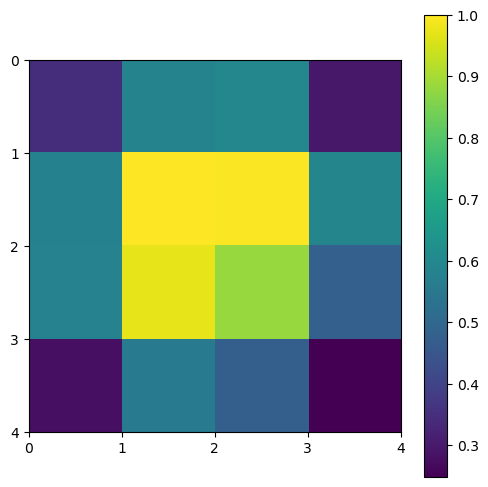

In [104]:
som = train_som(x, y, input_len, sigma, learning_rate)
plot_som(som)

#### QUANTIZATION TOPOGRAPHIC ERRORS OVER ITERATIONS

iteration=99999 status=100.00% error=63.120112717089554

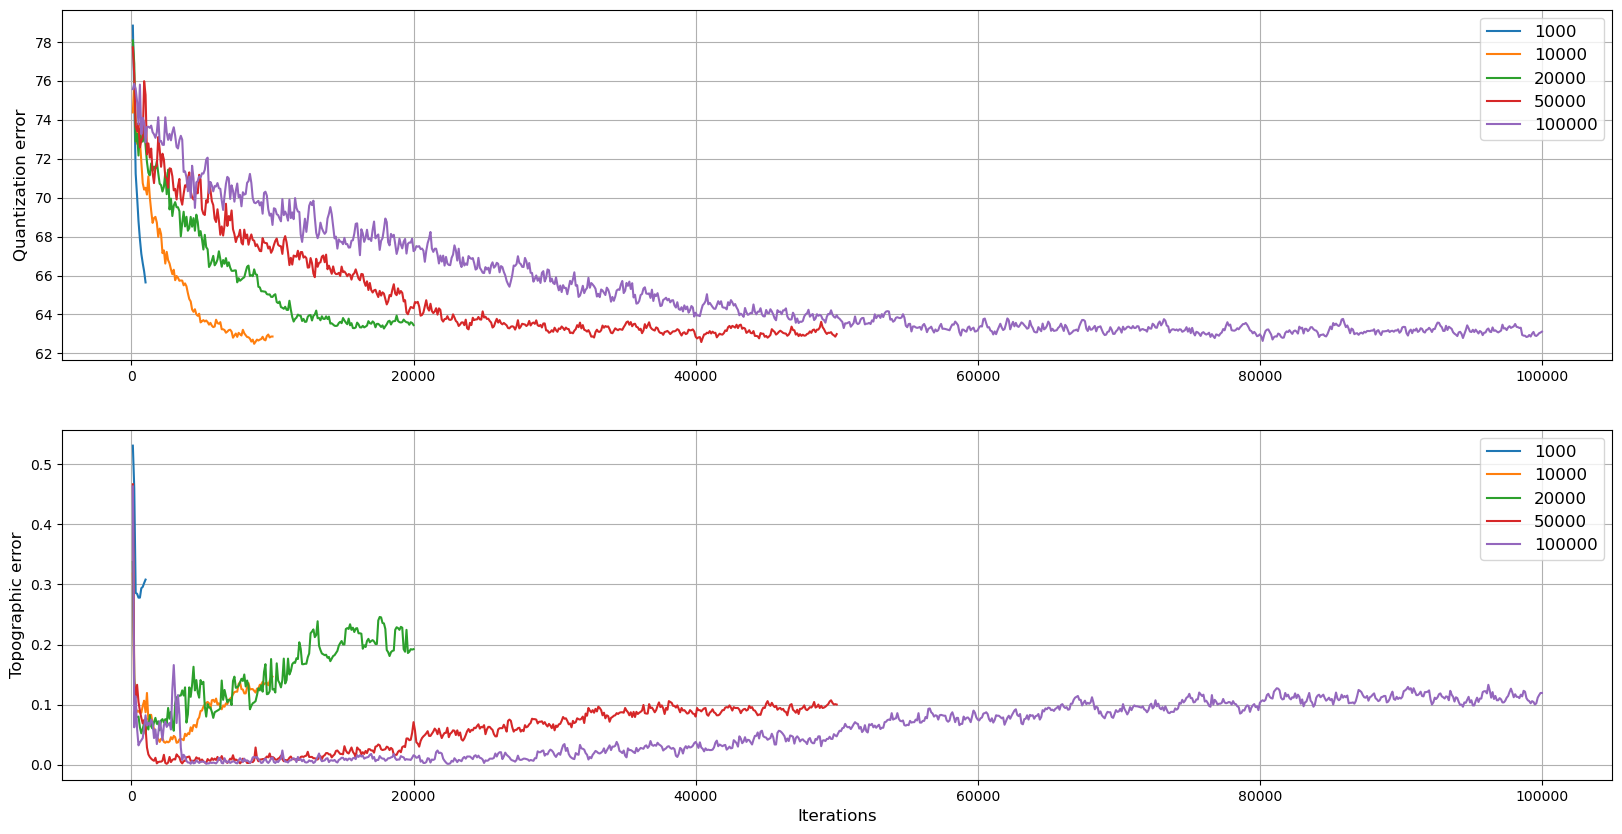

In [41]:
parameters = {'axes.labelsize':12, 'axes.titlesize':10, 'legend.fontsize':12, 'xtick.labelsize':10, 'ytick.labelsize':10, 
                  'legend.title_fontsize':10, 'figure.titlesize':25}
plt.rcParams.update(parameters)

max_iter = [1000,10000,20000,50000,100000]

fig, axs = plt.subplots(2,1,figsize=(20,10))
for num_iter in max_iter:
    som = MiniSom(x, y, input_len=input_len, sigma=sigma, learning_rate=learning_rate, 
                  neighborhood_function='gaussian', random_seed=10)
    som.random_weights_init(data)
    
    q_error_list = [] ; t_error_list = [] ; iter_x = []
    for i in range(num_iter):
        percent = 100*(i+1)/num_iter
        rand_i = np.random.randint(len(data))
        som.update(data[rand_i], som.winner(data[rand_i]), i, num_iter)
        if (i+1) % 100 == 0:
            q_error = som.quantization_error(data)
            t_error = som.topographic_error(data)
            q_error_list.append(q_error)
            t_error_list.append(t_error)
            iter_x.append(i)
            sys.stdout.write(f'\riteration={i:2d} status={percent:0.2f}% error={q_error}')
    axs[0].plot(iter_x,q_error_list, label='{}'.format(num_iter))
    axs[1].plot(iter_x,t_error_list, label='{}'.format(num_iter))
axs[0].set_ylabel('Quantization error')
axs[1].set_ylabel('Topographic error')
axs[1].set_xlabel('Iterations')
axs[0].legend()
axs[1].legend()
axs[0].grid()
axs[1].grid()

path_fig = '/lustre/storeB/users/justinec/master_internship/figures/era5_mosaic_SOM/'
plt.savefig(path_fig+'ERA5_rh_'+str(x*y)+'_s'+str(sigma)+'_lt'+str(learning_rate)+'_i'+str(iterations)+'_qerror.png',dpi=300)
#it converges faster with fewer iterations because the learning rate decreases when the number of iterations increases

#### Parameters from minisom library, usefull for plot

In [11]:
neuron_weights = som.get_weights()           # neuron weights for each neuron
win_map = som.win_map(data)                  # profiles sort by indices of neuron
nb_profiles = som.activation_response(data)  # number of profiles in each neuron
print('number of profiles : \n', nb_profiles)

number of profiles : 
 [[245.  95.  61.  58.]
 [106. 128.  73.  53.]
 [ 93.  63.  89.  60.]
 [ 97.  55.  65.  58.]]


#### Nodes activated more often (number of profiles in each neuron)

[Text(0, -0.5, '0'),
 Text(0, 0.5, '1'),
 Text(0, 1.5, '2'),
 Text(0, 2.5, '3'),
 Text(0, 3.5, '4')]

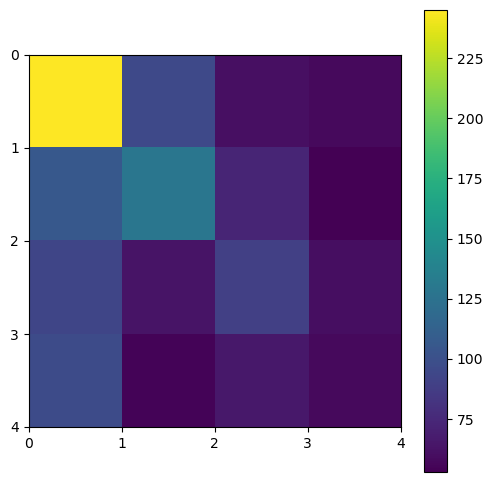

In [12]:
plt.figure(figsize=(6, 6))
nb_profiles = som.activation_response(data)
plt.imshow(nb_profiles)
plt.colorbar()
ax = plt.gca()
ax.set_xticks(np.arange(-.5, 4, 1))
ax.set_yticks(np.arange(-.5, 4, 1))
ax.set_xticklabels(np.arange(0, 5, 1))
ax.set_yticklabels(np.arange(0, 5, 1))

In [13]:
np.shape(som._distance_from_weights(data))
som._distance_from_weights(data)[0,:]

array([ 90.62500045,  54.73865381,  80.90575034, 135.8563754 ,
       124.93207384,  48.99732505, 126.03740522, 130.83906569,
        98.30330346, 174.94023471, 166.28614597, 150.87005803,
       210.72646738, 253.28091718, 236.08688471, 205.02460383])

#### MEAN SQUARED ERROR, ROOT MEAN SQUARED ERROR, QUANTIZATION ERROR IN EACH NEURON AND IN TOTAL

In [31]:
# Create dictionaries with neuron_name being the corresponding neuron 
mae_neuron_list = {} ; rmse_neuron_list = {} ; q_error_neuron_list = {} ; q_error_2_neuron_list = {}
for i in range(0,x):
    for j in range(0,y):
        neuron_name = 'neuron_'+str(i)+'_'+str(j)
        mae_neuron_list[neuron_name] = []
        rmse_neuron_list[neuron_name] = []
        q_error_neuron_list[neuron_name] = []
        q_error_2_neuron_list[neuron_name] = []

In [32]:
winner_list=[] ; mae_list=[] ; rmse_list=[] ; q_error_list = [] ; q_error_2_list=[]
bmu = som.quantization(data) #BMU for each temperature profile (neuron_weight corresponding to each temperature profile)

for ix in range(len(data)):
    winner = som.winner(data[ix]) #(i,j) indexes of the winner neuron for each profile
    winner_list.append(winner)
    
    # For one profile :
    mae = mean_absolute_error(data[ix],bmu[ix]) #abs(np.subtract(data[ix],bmu[ix])).mean()
    mse = mean_squared_error(data[ix],bmu[ix]) #np.square(np.subtract(data[ix],bmu[ix])).mean()
    rmse = np.sqrt(mse)
    q_error = norm(data[ix]-bmu[ix]) #error along the profile
    q_error_2 = np.sqrt(norm(data[ix]-bmu[ix])**2/len(data[ix])) #error per pressure level
    
    # List of values for all profiles :
    mae_list.append(mae)
    rmse_list.append(rmse)
    q_error_list.append(q_error)
    q_error_2_list.append(q_error_2)
    
    # Putting values in corresponding neuron of the dictionary :
    neuron_name = 'neuron_'+str(winner[0])+'_'+str(winner[1])
    mae_neuron_list[neuron_name].append(mae)
    rmse_neuron_list[neuron_name].append(rmse)
    q_error_neuron_list[neuron_name].append(q_error)
    q_error_2_neuron_list[neuron_name].append(q_error_2)

In [33]:
# Mean in each neuron
mae_neuron=[] ; rmse_neuron=[] ; q_error_neuron=[] ; q_error_2_neuron=[]
for i in range(0,x) :
    for j in range(0,y):
        neuron_name = 'neuron_'+str(i)+'_'+str(j)
        mae_neuron.append(np.mean(mae_neuron_list[neuron_name]))
        rmse_neuron.append(np.mean(rmse_neuron_list[neuron_name]))
        q_error_neuron.append(np.mean(q_error_neuron_list[neuron_name]))
        q_error_2_neuron.append(np.mean(q_error_2_neuron_list[neuron_name]))

In [34]:
# On all profiles (my calcul)
total_mae = np.mean(mae_list)
total_rmse = np.mean(rmse_list)
total_q_error = np.mean(q_error_list)
total_q_error_2 = np.mean(q_error_2_list)

In [35]:
# On all profiles (from python functions)
mae_total = mean_absolute_error(data,bmu) #per profile, per pressure level
mse_total = mean_squared_error(data,bmu) #per profile, per pressure level
rmse_total = np.sqrt(mse_total) #per profile, per pressure level
q_error_total = som.quantization_error(data) #per profile on all pressure levels

In [36]:
print('My calcul : \n mae : {} K (per level pressure and per profile) \nrmse : {} K (per level pressure and per profile) \nq_error :  {} K (per profile) \n'.format(total_mae, total_rmse, total_q_error))
print('Calcul from python functions : \n mae : {} K\nrmse : {} K \nq_error :  {} K \n'.format(mae_total, rmse_total, q_error_total))
print('q_error per profile and per pressure level : {} K'.format(total_q_error_2))

My calcul : 
 mae : 9.277367101037854 K (per level pressure and per profile) 
rmse : 11.658696978299618 K (per level pressure and per profile) 
q_error :  62.78400466458449 K (per profile) 

Calcul from python functions : 
 mae : 9.277367101037855 K
rmse : 12.628556953817398 K 
q_error :  62.78400466458449 K 

q_error per profile and per pressure level : 11.658696978299618 K


### PLOT

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


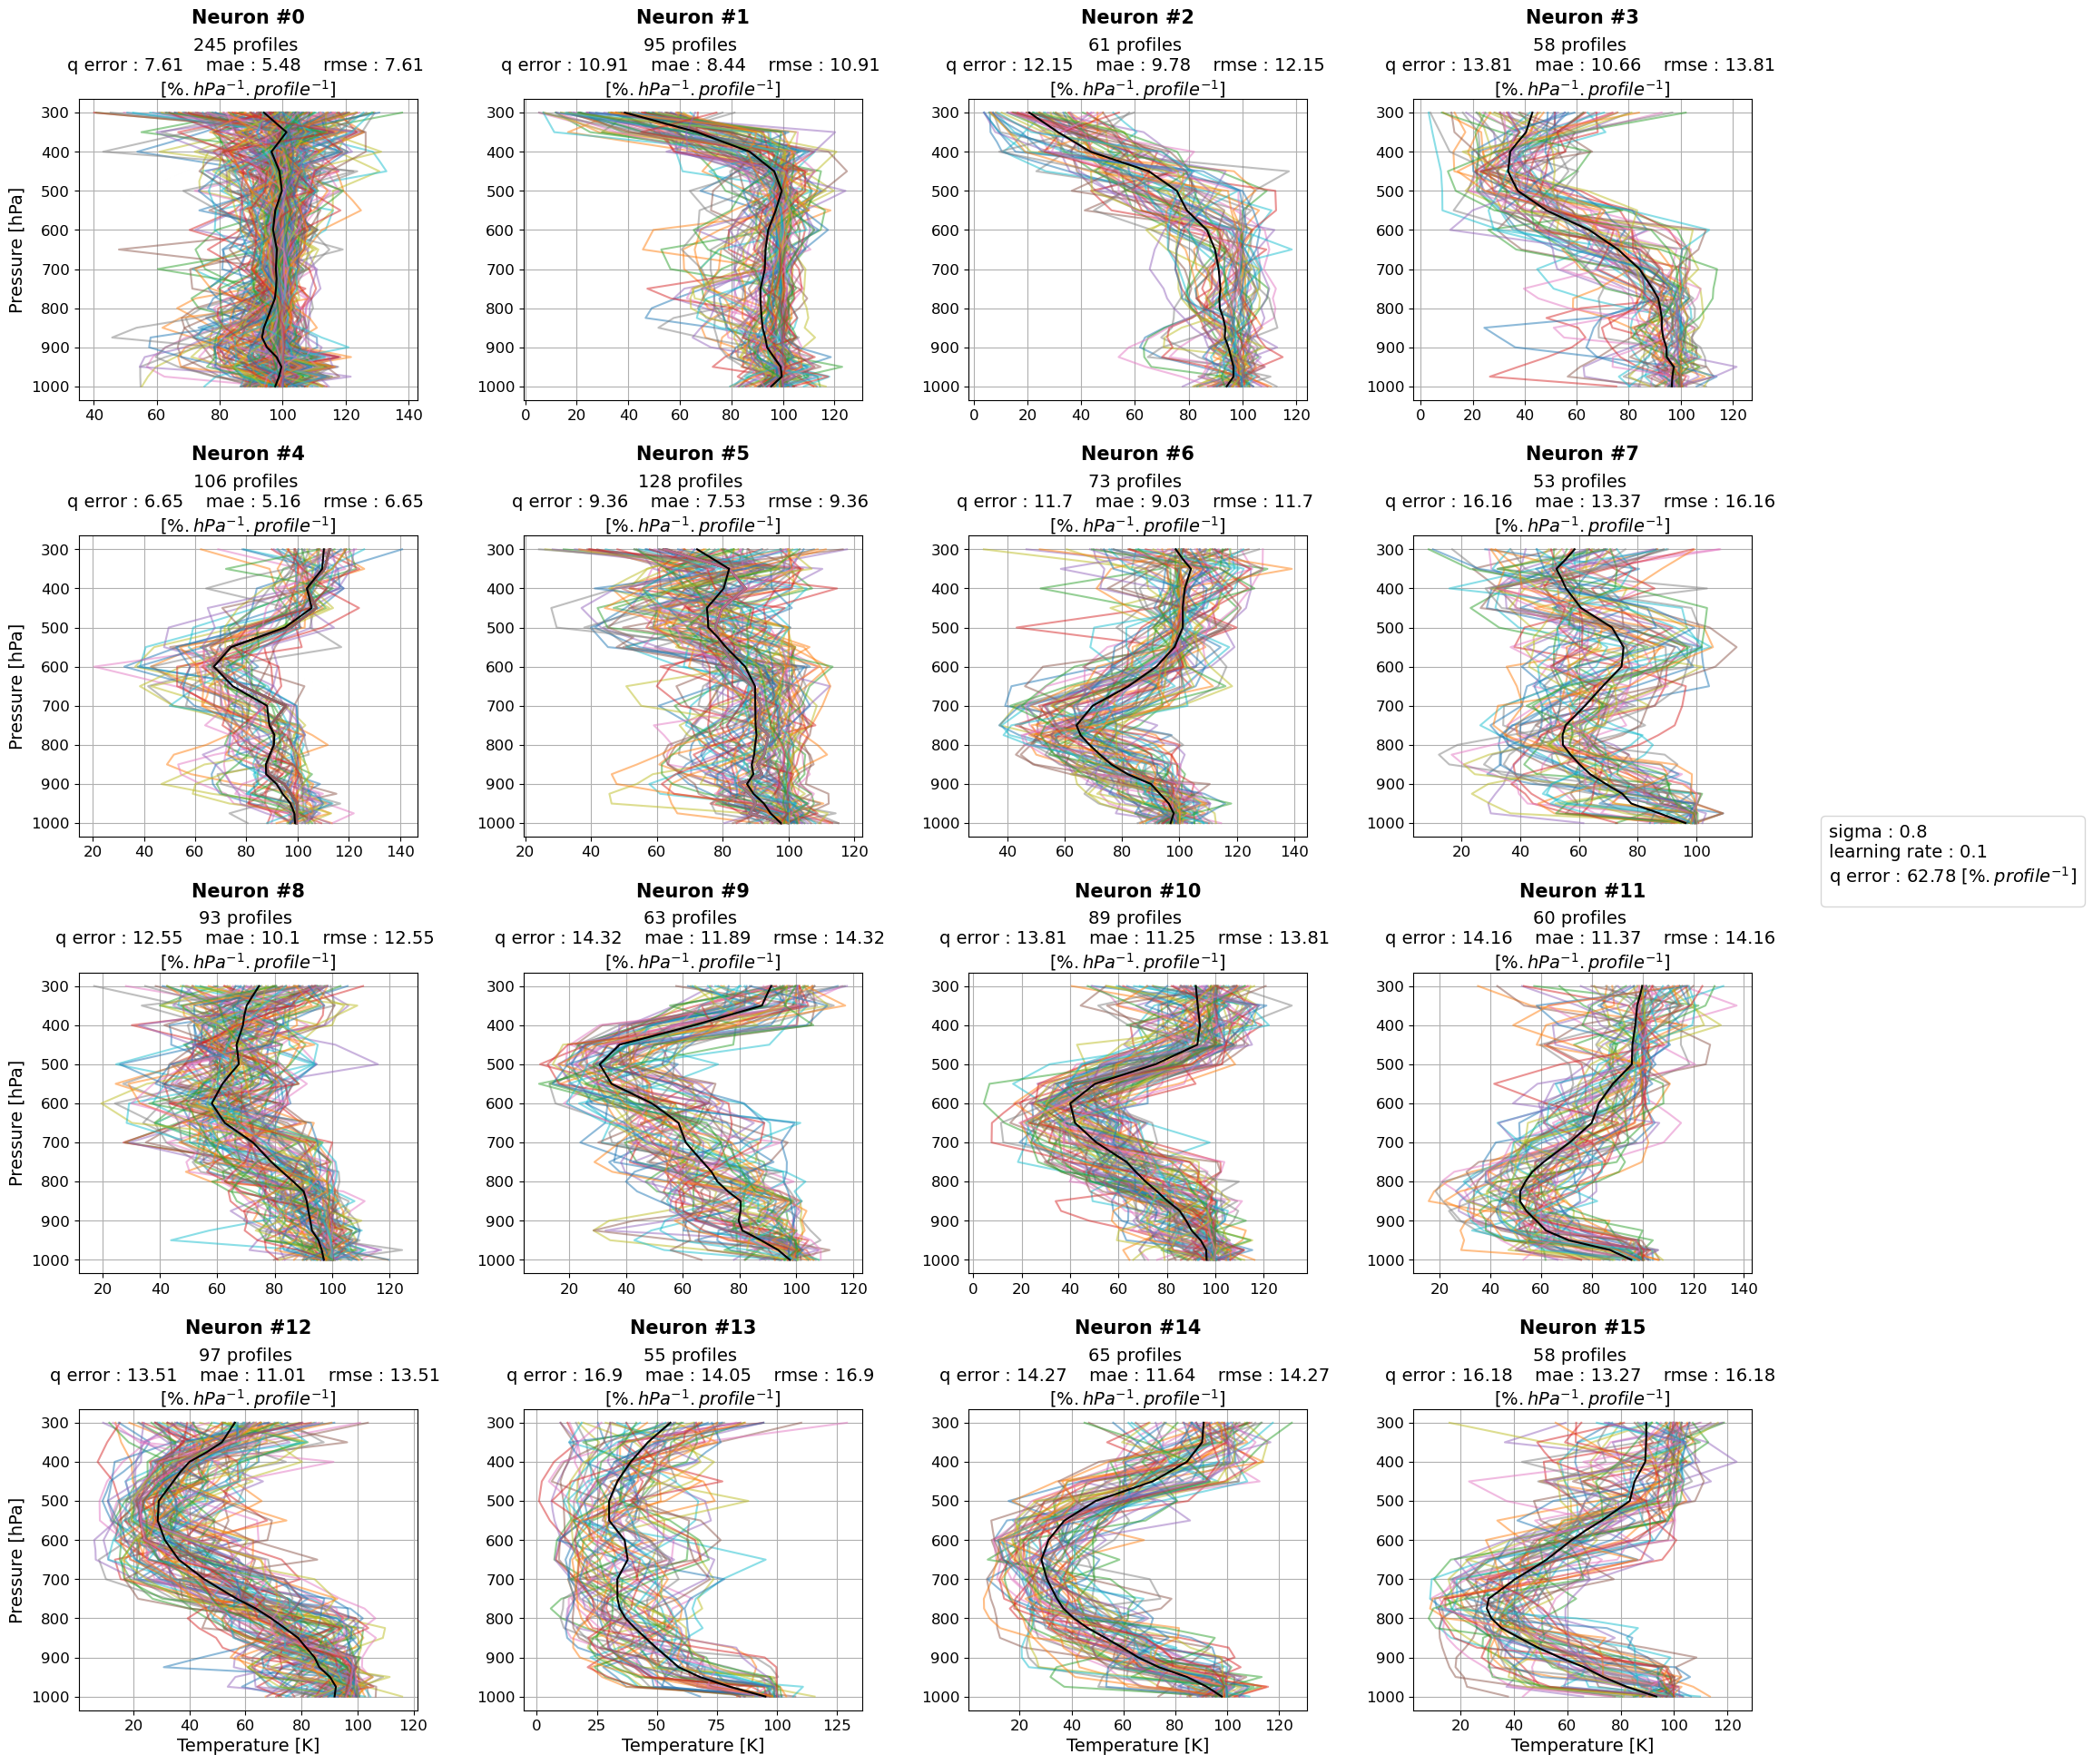

In [40]:
parameters = {'axes.labelsize':14, 'axes.titlesize':15, 'legend.fontsize':16, 'xtick.labelsize':12, 'ytick.labelsize':12, 
                  'legend.title_fontsize':14, 'figure.titlesize':25}
plt.rcParams.update(parameters)

fig, axs = plt.subplots(x,y,figsize=(20,20))
t=0
for i in range(0,x) :
     for n in range(0,y) :
        for m in range(len(win_map[(i,n)])) :
            axs[i,n].plot(win_map[(i,n)][m], pres, alpha=0.5)
        axs[i,n].plot(neuron_weights[i][n], pres, 'k')
        axs[i,n].invert_yaxis()
        axs[i,n].grid()
        axs[i,n].set_title('Neuron #'+str(t), pad=60, weight='bold')
        axs[i,n].text(0.5,1.1, '{} profiles \nq error : {}    mae : {}    rmse : {} \n[$\%.hPa^{{-1}}.profile^{{-1}}$]'.format(int(nb_profiles[i][n]),
            np.round(q_error_2_neuron[t],2), np.round(mae_neuron[t],2), np.round(rmse_neuron[t], 2)), horizontalalignment='center',
                      verticalalignment='center', transform = axs[i,n].transAxes, fontsize=14)
        if n==0 :
            axs[i,n].set_ylabel('Pressure [hPa]')
        if i>2 :
            axs[i,n].set_xlabel('Temperature [K]')
       
        t = t+1
        
fig.tight_layout()        
fig.subplots_adjust(top=0.92, hspace=0.45)
lgd = fig.legend(loc='center left',  bbox_to_anchor=(1, 0.5), title='sigma : {} \nlearning rate : {} \nq error : {} [$\%.profile^{{-1}}$]'.format(np.round(sigma,2),
                                                                                                        np.round(learning_rate,2),
                                                                                                        np.round(q_error_total,2)))

path_fig = '/lustre/storeB/users/justinec/master_internship/figures/era5_mosaic_SOM/'
plt.savefig(path_fig+'ERA5_rh_'+str(x*y)+'_s'+str(sigma)+'_lt'+str(learning_rate)+'_i'+str(iterations)+'_SOM.png',dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')